# SLA1 Camera Characterization

## Calibration of 30s Darks

On May 8, 2024 (UTC) we took various dark exposures with the [QHY42 Pro](https://www.qhyccd.com/qhy42pro/) camera.

This notebook combines the darks into a master dark, and then subtracts them from each individual dark
with the goal of characterizing hot pixels and dark current.


In [1]:
# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.

import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, combine, subtract_dark, flat_correct # Combiner
import astroalign as aa
import matplotlib.pyplot as plt
%matplotlib inline

# soft link to directory containing images downloaded from SLA1
sessions_directory = os.path.join(os.path.expanduser('~'), '2024 SLA Sessions')
# soft link to git directory containing this notebook
analysis_directory = os.path.join(os.path.expanduser('~'), 'analyses-30s_darks')

# The path to the first dark on SLA1 is
# D:/Raw/2024-05-08/03_38_48/Dark30s/00001.fits
# The files to be processed are expected to be mirrored on the local machine
# at ~/2024 SLA Sessions/ using the same subdirectory structure.
capture_date = '2024-05-08'
capture_time = '03_38_48'
object_name = 'Dark30s'

# subdirectory for the 10-second darks (following SharpCap Pro capture directory conventions)
dark_directory = os.path.join(
    sessions_directory,
    capture_date,
    capture_time,
    object_name
)

# exposure duration

dark_exposure = 30.0
dark_exposure_with_ccdproc_units = dark_exposure * u.second

def confirm_fits_header(image, dimensions, exposure_time, filter):
    header = image.header
    assert header['NAXIS1'] == dimensions[0]
    assert header['NAXIS2'] == dimensions[1]
    assert header['EXPTIME'] == exposure_time
    if filter:
        assert header['FILTER'].rstrip() == filter

dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')

darks = [CCDData.read(file, unit=u.adu) for file in dark_files]

for dark in darks:
    confirm_fits_header(dark, (2048, 2048), dark_exposure, None)

combination_method = 'median'  # alternatively, the method can be 'average'

master_dark = combine(darks, method=combination_method)


Set MJD-END to 60438.151953 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.151953 from DATE-END'.
Set MJD-END to 60438.152301 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152301 from DATE-END'.
Set MJD-END to 60438.152648 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152648 from DATE-END'.
Set MJD-END to 60438.152995 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152995 from DATE-END'.
Set MJD-END to 60438.153342 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.153342 from DATE-END'.
Set MJD-END to 60438.153689 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.153689 from DATE-END'.
Set MJD-END to 60438.154037 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154037 from DATE-END'.
Set MJD-END to 60438.154384 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154384 from DATE-END'.
Set MJD-END to 60438.154731 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154731 from DATE-END'.
Set MJD-END to 60438.155078 from DATE-END'. [a

## Calibrate the Darks by Subtracting the Master Dark

In [2]:
subtracted_darks = [
    subtract_dark(
        dark,
        master_dark,
        data_exposure=dark_exposure_with_ccdproc_units,
        dark_exposure=dark_exposure_with_ccdproc_units,
        scale=False)
    for dark in darks
]


## Display the Master Dark

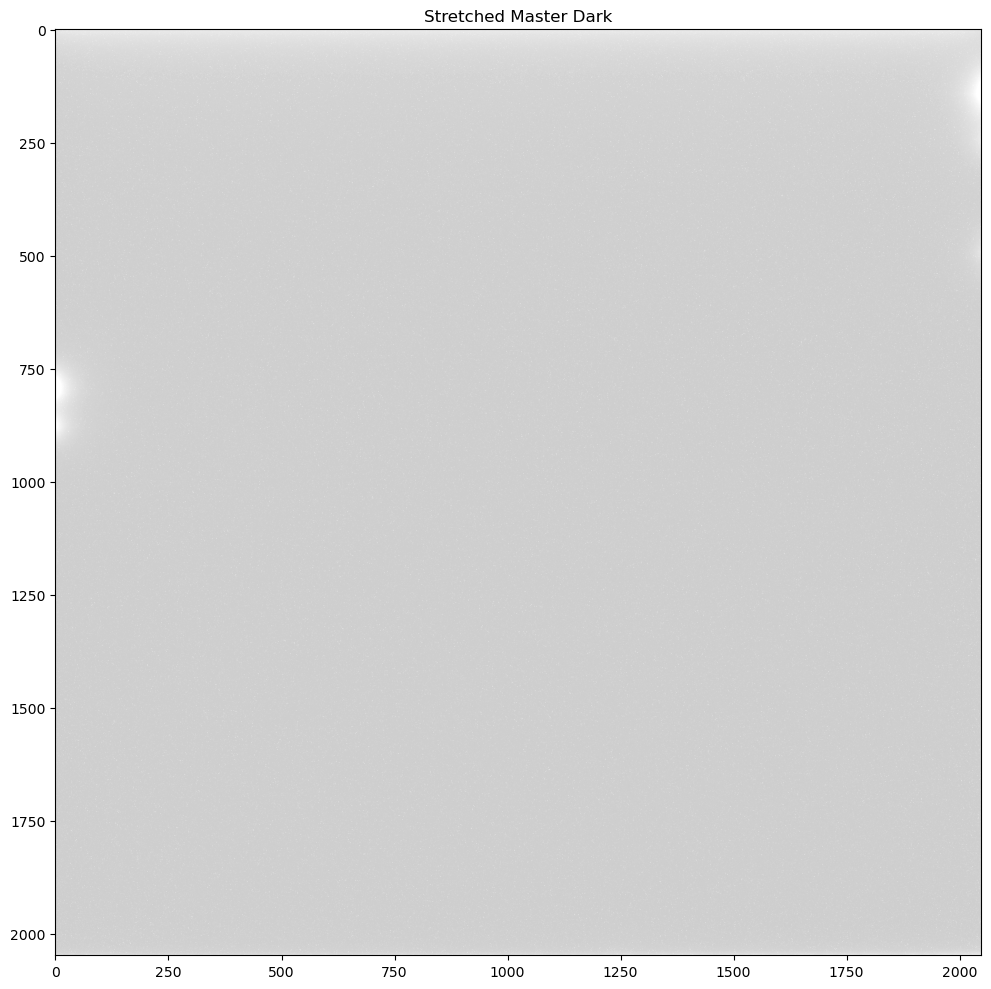

In [3]:
# Log stretch

# Log stretch utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        # The bizarre first conditional test on the next line avoids any attempt to transform NaNs.
        # if pixel_value != pixel_value or pixel_value <= 1.0:
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn


stretch_function = log_stretch_transform(0, 50000)
stretch_transform = np.vectorize(stretch_function)

stretched_master_dark = stretch_transform(master_dark.data)

# Display the master dark

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.imshow(stretched_master_dark.data, cmap='gray')
axes.set_title("Stretched Master Dark")

plt.tight_layout()
plt.show()


## Display a Representative Dark

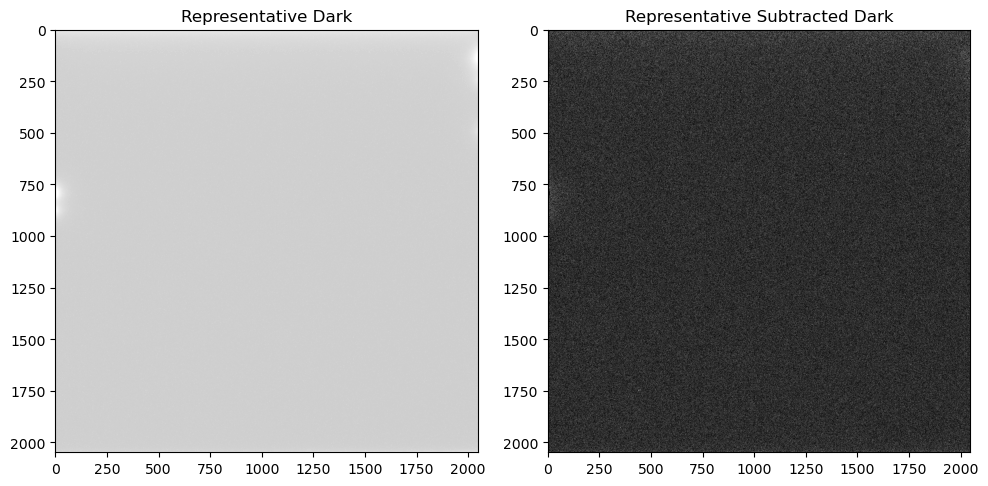

In [4]:
stretched_darks = [
    stretch_transform(dark.data) for dark in darks
]
stretched_subtracted_darks = [
    stretch_transform(subtracted_dark.data) for subtracted_dark in subtracted_darks
]

# Display a representative dark, both without and with subtraction

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(stretched_darks[5].data, cmap='gray')
axes[0].set_title("Representative Dark")

axes[1].imshow(stretched_subtracted_darks[5].data, cmap='gray')
axes[1].set_title("Representative Subtracted Dark")

plt.tight_layout()
plt.show()


In [5]:
darks[5].data

array([[ 6400, 61638,     0, ..., 14966, 14966, 14288],
       [ 5741,  5741, 17478, ..., 15172, 16338, 14002],
       [17457, 18224, 17478, ..., 14268, 16087, 16234],
       ...,
       [ 7993,  9072,  8196, ..., 15131, 15921, 15691],
       [ 8791,  9148,  9507, ..., 18760, 19255, 17520],
       [11029, 18374, 11557, ..., 28432, 24336, 25038]], dtype=uint16)

In [6]:
subtracted_darks[5].data

array([[   0. ,  128. ,   -3.5, ...,   21. ,  -10.5, -102. ],
       [   0. ,    0. , -127.5, ...,  730.5, -379. , -194. ],
       [ 244. ,  331. , -447. , ..., -142. , 1110.5,  -94. ],
       ...,
       [ -18. ,  168.5, -148. , ..., -373.5,  769. ,  -94. ],
       [ -37.5,   19. ,   18.5, ...,  215. ,   64.5, -404.5],
       [ 563.5,  -10.5,  235.5, ...,  602. , -837. ,  419.5]])

In [7]:
stretched_darks[5]

array([[207, 255,   0, ..., 227, 227, 226],
       [204, 204, 231, ..., 227, 229, 225],
       [231, 232, 231, ..., 226, 229, 229],
       ...,
       [212, 215, 213, ..., 227, 228, 228],
       [214, 215, 216, ..., 232, 233, 231],
       [220, 232, 221, ..., 242, 238, 239]])

In [8]:
stretched_subtracted_darks[5]

array([[  0, 114,   0, ...,  72,   0,   0],
       [  0,   0,   0, ..., 156,   0,   0],
       [130, 137,   0, ...,   0, 165,   0],
       ...,
       [  0, 121,   0, ...,   0, 157,   0],
       [  0,  69,  69, ..., 127,  98,   0],
       [149,   0, 129, ..., 151,   0, 142]])

In [9]:
master_dark.data

array([[6.40000e+03, 6.15100e+04, 3.50000e+00, ..., 1.49450e+04,
        1.49765e+04, 1.43900e+04],
       [5.74100e+03, 5.74100e+03, 1.76055e+04, ..., 1.44415e+04,
        1.67170e+04, 1.41960e+04],
       [1.72130e+04, 1.78930e+04, 1.79250e+04, ..., 1.44100e+04,
        1.49765e+04, 1.63280e+04],
       ...,
       [8.01100e+03, 8.90350e+03, 8.34400e+03, ..., 1.55045e+04,
        1.51520e+04, 1.57850e+04],
       [8.82850e+03, 9.12900e+03, 9.48850e+03, ..., 1.85450e+04,
        1.91905e+04, 1.79245e+04],
       [1.04655e+04, 1.83845e+04, 1.13215e+04, ..., 2.78300e+04,
        2.51730e+04, 2.46185e+04]])